<a href="https://colab.research.google.com/github/JKEVIN2010/Dementia-Linguistic-Biomarkers/blob/main/First_Order_Markov_for_Early_Dementia_Screening_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
from scipy.linalg import eig
from scipy.stats import ks_2samp
import re
import os
from itertools import product
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')

In [ ]:
# Load the CSV file
file_path = 'cookie.csv'
data = pd.read_csv(file_path)

# Visualize data
data.head()


,Unnamed: 0,utts,labels
0,142,well â€¡ the stool is falling over . the boy i...,0
1,355,these two little kids are getting cookies out ...,1
2,79,mhm . there is a boy and a girl and the boy is...,0
3,366,the girls trying ... did I get that ? and gir...,1
4,215,there is a girl waiting to get a cookie from I...,0


In [ ]:
# Function to clean text: lowercase, and remove special characters
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char in string.ascii_lowercase or char in ' '])
    return text

# Apply cleaning function to the 'utts' column
data['clean_utts'] = data['utts'].apply(clean_text)

# Display the cleaned text
data.head()


,Unnamed: 0,utts,labels,clean_utts
0,142,well â€¡ the stool is falling over . the boy i...,0,well the stool is falling over the boy is ta...
1,355,these two little kids are getting cookies out ...,1,these two little kids are getting cookies out ...
2,79,mhm . there is a boy and a girl and the boy is...,0,mhm there is a boy and a girl and the boy is ...
3,366,the girls trying ... did I get that ? and gir...,1,the girls trying did i get that and girl th...
4,215,there is a girl waiting to get a cookie from I...,0,there is a girl waiting to get a cookie from i...


In [ ]:
# Create a set of all characters in the cleaned utterances
characters = set(''.join(data['clean_utts']))

# Display all characters
characters

{' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [ ]:
# Compute transition matrix
def compute_transition_matrix(text, alpha=0.01):
    matrix_size = len(characters)  # There are 27 characters including space
    transition_matrix = np.zeros((matrix_size, matrix_size))
    char_indices = {char: idx for idx, char in enumerate(sorted(characters))}

    # Populate the transition matrix with character counts
    for i in range(len(text) - 1):
        if text[i] in char_indices and text[i+1] in char_indices:
            current_idx = char_indices[text[i]]
            next_idx = char_indices[text[i+1]]
            transition_matrix[current_idx, next_idx] += 1

    # Add Laplace smoothing
    transition_matrix += alpha

    # Convert counts to probabilities
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    return transition_matrix

# Compute steady-state probabilities
def compute_steady_state(transition_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    primary_index = np.argmin(np.abs(eigenvalues - 1))
    primary_vector = np.real(eigenvectors[:, primary_index])
    steady_state = primary_vector / primary_vector.sum()  # Normalize
    return steady_state



# Process each utterance to compute steady state probabilities
transition_matrices = data['clean_utts'].apply(compute_transition_matrix)
steady_states = transition_matrices.apply(compute_steady_state)

# Create DataFrame for the steady state probabilities
steady_state_df = pd.DataFrame(list(steady_states), columns=sorted(characters))
steady_state_df['label'] = data['labels']


In [ ]:
# Show steady-state probability database
steady_state_df

,,a,b,c,d,e,f,g,h,i,...,r,s,t,u,v,w,x,y,z,label
0,0.224689,0.047257,0.005961,0.019272,0.019161,0.079623,0.021976,0.029634,0.058955,0.071802,...,0.034878,0.042955,0.095960,0.021883,0.003362,0.014027,0.000708,0.003362,0.000708,0
1,0.233940,0.050999,0.004591,0.016721,0.030900,0.090973,0.006602,0.028848,0.058519,0.075107,...,0.032796,0.069201,0.065036,0.016714,0.004583,0.014676,0.000544,0.008611,0.000544,1
2,0.226738,0.055523,0.006000,0.015193,0.037135,0.080676,0.007799,0.020644,0.060473,0.071972,...,0.037053,0.062801,0.084901,0.011441,0.004120,0.013290,0.000487,0.007776,0.000487,0
3,0.243392,0.068476,0.008547,0.012373,0.038752,0.075106,0.001012,0.034992,0.059617,0.083893,...,0.034626,0.079706,0.083634,0.008586,0.001012,0.023493,0.001012,0.019751,0.001012,1
4,0.212496,0.037822,0.008124,0.018096,0.022983,0.091338,0.013040,0.027928,0.056525,0.079681,...,0.050004,0.055082,0.070059,0.013063,0.005606,0.032974,0.000667,0.005633,0.000667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0.223683,0.023881,0.012898,0.012898,0.018468,0.082826,0.007202,0.035177,0.054810,0.089944,...,0.045864,0.040331,0.079324,0.012748,0.007127,0.007202,0.001506,0.018293,0.001506,1
548,0.197138,0.058558,0.017083,0.021614,0.039472,0.102084,0.007001,0.023803,0.063033,0.054030,...,0.046056,0.042814,0.075220,0.022505,0.003616,0.022681,0.000302,0.017068,0.001420,0
549,0.218975,0.057122,0.004763,0.009224,0.032470,0.090250,0.008106,0.029081,0.071462,0.078175,...,0.044715,0.058950,0.084848,0.010313,0.003639,0.011449,0.000300,0.009182,0.000300,0
550,0.222286,0.059515,0.010503,0.017762,0.034951,0.085665,0.015326,0.027539,0.053860,0.085867,...,0.037178,0.054364,0.083770,0.017729,0.010364,0.017751,0.000653,0.010429,0.000653,1


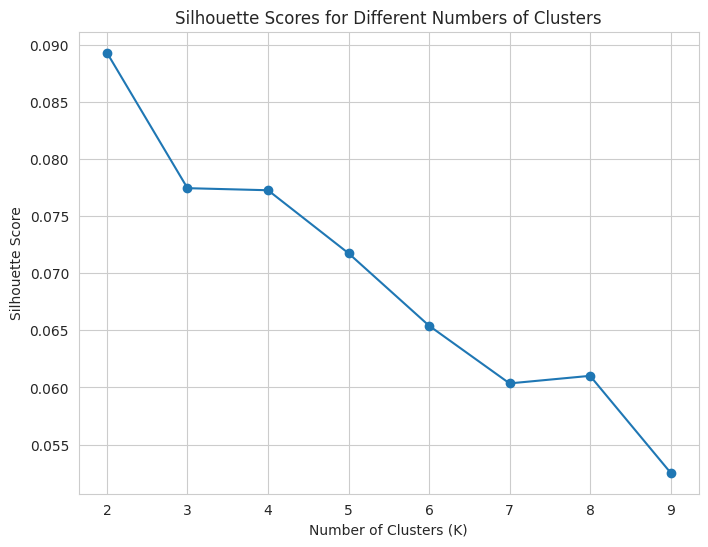

In [ ]:
# Extract features for clustering (exclude the 'label' column)
features = steady_state_df.drop('label', axis=1)

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
K_range = range(2, 10)  # Testing for 2 to 9 clusters

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.grid(True)
plt.show()


In [ ]:
# Perform K-Means clustering with the optimal number of clusters found (K=2)
kmeans_optimal = KMeans(n_clusters=2, random_state=42)
clusters = kmeans_optimal.fit_predict(features)

# Add the cluster labels to the DataFrame
steady_state_df['cluster'] = clusters

# Reduce dimensions to 2 for visualization using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

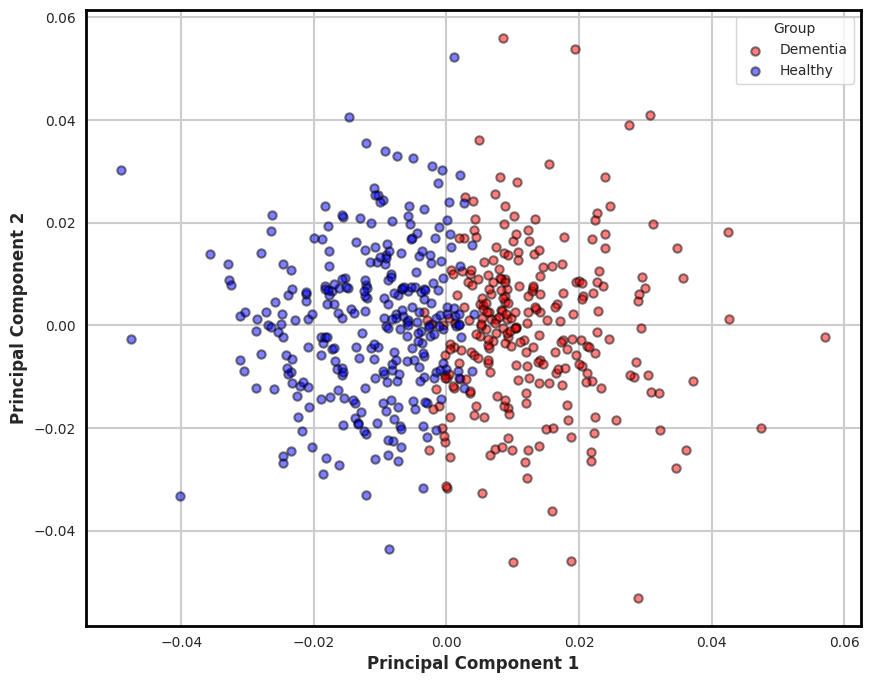

In [ ]:
# Assuming 'pca_features' is the PCA result array and 'clusters' contains cluster assignments as a NumPy array
clusters_series = pd.Series(clusters)  # Convert clusters to a pandas Series
cluster_label_map = {0: 'Dementia', 1: 'Healthy'}  # Map of cluster indices to labels
colors = {'Dementia': 'red', 'Healthy': 'blue'}

# Map your cluster numbers to names
labels = clusters_series.map(cluster_label_map)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    subset = reduced_features[labels == label,:]  # Adjust to correctly reference your PCA results array
    plt.scatter(subset[:, 0], subset[:, 1], c=colors[label], label=label, edgecolors='black', linewidths=1.5, alpha=0.5)

# Enhancing x-axis and y-axis titles with bold font
plt.xlabel('Principal Component 1', fontsize=12, fontweight='bold')
plt.ylabel('Principal Component 2', fontsize=12, fontweight='bold')

# Styling the legend
plt.legend(title='Group', loc='upper right', frameon=True)

# Enhancing borders
ax = plt.gca()  # Get the current Axes instance on the current figure
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

# Optionally, you can make the grid bold as well
ax.grid(True, linestyle='-', linewidth=1.5)

plt.show()


In [ ]:
# Initialize a DataFrame to store KS test results
ks_results = pd.DataFrame(columns=['Character', 'KS Statistic', 'P-Value'])

for char in steady_state_df.columns.drop(['label', 'cluster']):  # exclude the label column
    group0 = steady_state_df[steady_state_df['label'] == 0][char]
    group1 = steady_state_df[steady_state_df['label'] == 1][char]
    ks_stat, p_value = ks_2samp(group0, group1)
    # Create a DataFrame for the current result and concat it
    current_result = pd.DataFrame({
        'Character': [char],
        'KS Statistic': [ks_stat],
        'P-Value': [p_value]
    })
    ks_results = pd.concat([ks_results, current_result], ignore_index=True)

# Display the KS test results sorted by P-Value
ks_results.sort_values(by='P-Value', inplace=True)
print(ks_results)



   Character  KS Statistic       P-Value
0                 0.286148  2.504767e-10
14         n      0.193296  6.227298e-05
9          i      0.192017  7.125684e-05
3          c      0.183627  1.709073e-04
8          h      0.181190  2.185870e-04
24         x      0.175037  4.011332e-04
12         l      0.170882  5.969756e-04
6          f      0.168205  7.673360e-04
25         y      0.163730  1.157381e-03
10         j      0.158256  1.885072e-03
4          d      0.142954  6.742967e-03
26         z      0.136202  1.135346e-02
2          b      0.134604  1.280148e-02
15         o      0.130409  1.739958e-02
22         v      0.126893  2.234504e-02
18         r      0.121739  3.185363e-02
17         q      0.114787  5.016602e-02
11         k      0.114747  5.029748e-02
20         t      0.113069  5.591077e-02
23         w      0.112070  5.950209e-02
13         m      0.102841  1.030080e-01
21         u      0.099245  1.259146e-01
16         p      0.093372  1.721741e-01
5          e    

In [ ]:
print("Top significant features based on p-values:")
print(ks_results.head())  # Shows the features with the lowest p-values

Top significant features based on p-values:
   Character  KS Statistic       P-Value
0                 0.286148  2.504767e-10
14         n      0.193296  6.227298e-05
9          i      0.192017  7.125684e-05
3          c      0.183627  1.709073e-04
8          h      0.181190  2.185870e-04


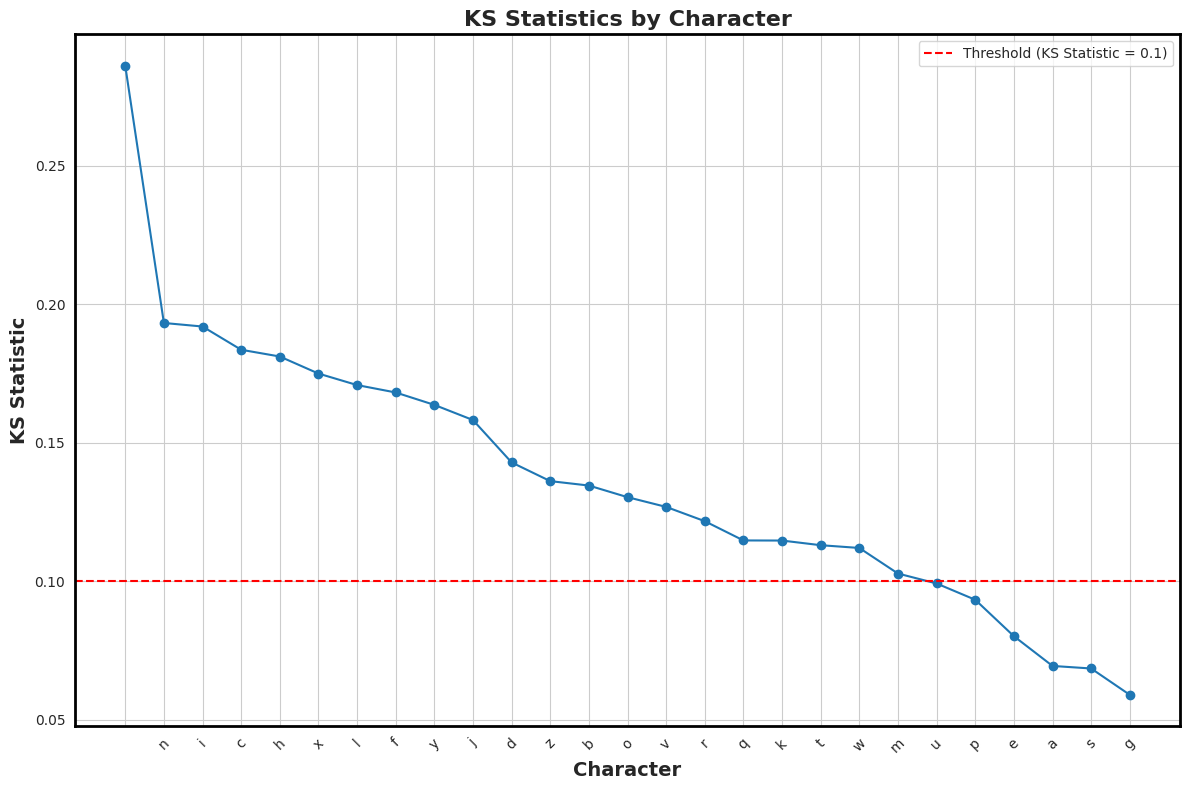

In [ ]:
# Sorting data by KS Statistic for better visualization
ks_results_sorted = ks_results.sort_values('KS Statistic', ascending=False)

# Creating a line plot
plt.figure(figsize=(12, 8))
plt.plot(ks_results_sorted['Character'], ks_results_sorted['KS Statistic'], marker='o', linestyle='-')
threshold = 0.1  # Example threshold value
plt.axhline(threshold, ls='--', color='red', label=f'Threshold (KS Statistic = {threshold})')
plt.title('KS Statistics by Character', fontsize=16, fontweight='bold')
plt.xlabel('Character', fontsize=14, fontweight='bold')
plt.ylabel('KS Statistic', fontsize=14, fontweight='bold')

# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase linewidth
    spine.set_color('black')  # Set color to black

plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


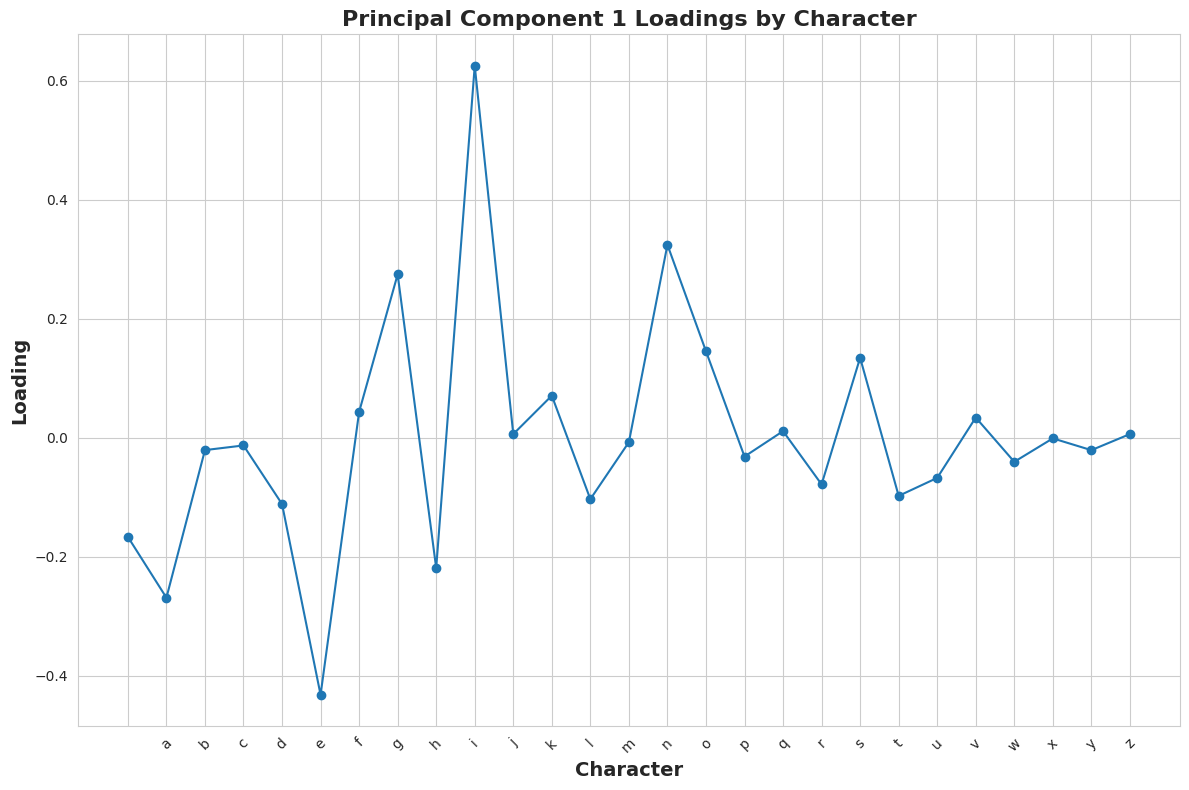

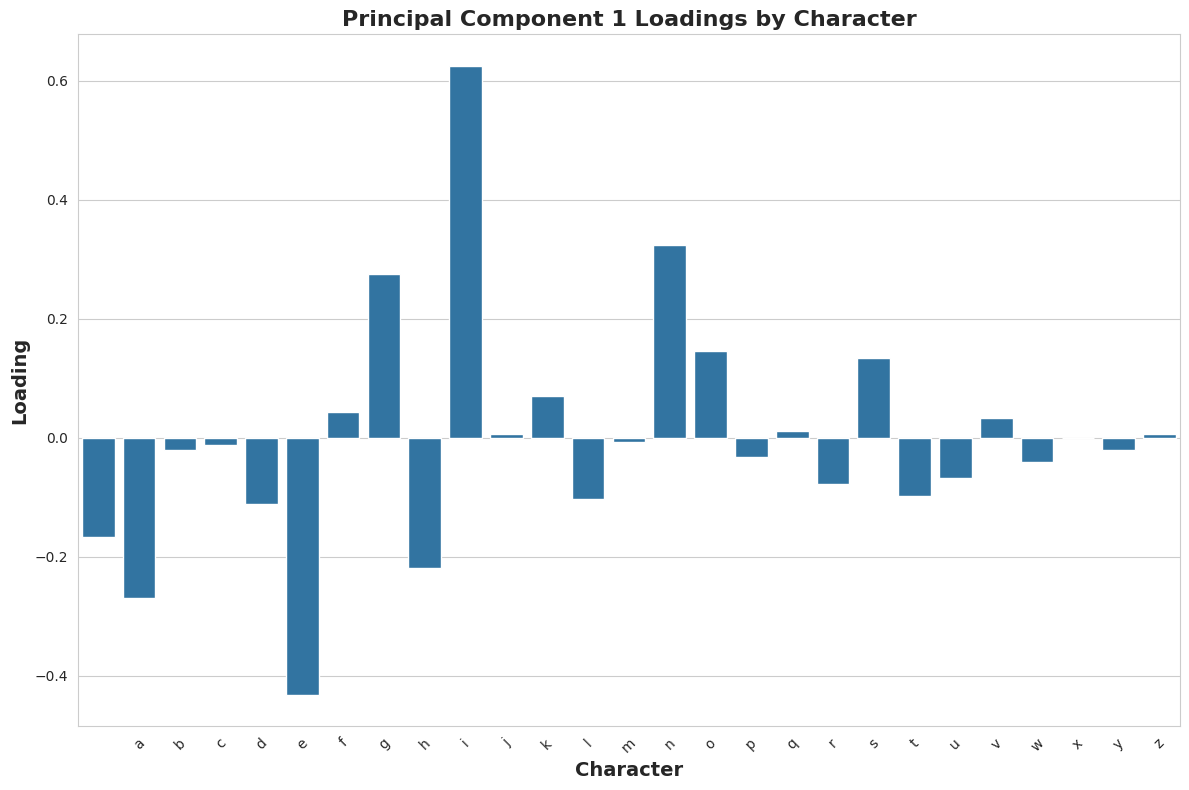

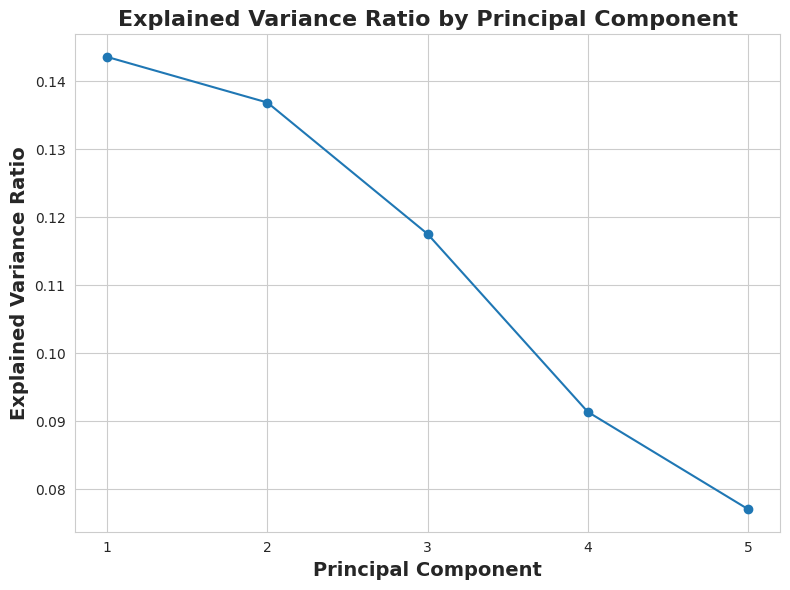

In [ ]:
# Fit PCA with desired number of components
pca = PCA(n_components=5)
principal_components = pca.fit_transform(features)
component_loadings = pca.components_

# Get the list of characters (features)
characters = features.columns.tolist()

# Create a DataFrame for the component loadings
loadings_df = pd.DataFrame(component_loadings.T, columns=[f'PC{i+1}' for i in range(component_loadings.shape[0])], index=characters)

# Line plot for PC1 loadings
plt.figure(figsize=(12, 8))
plt.plot(loadings_df.index, loadings_df['PC1'], marker='o', linestyle='-')
plt.title('Principal Component 1 Loadings by Character', fontsize=16, fontweight='bold')
plt.xlabel('Character', fontsize=14, fontweight='bold')
plt.ylabel('Loading', fontsize=14, fontweight='bold')

# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase linewidth
    spine.set_color('black')  # Set color to black

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plot for PC1 loadings
plt.figure(figsize=(12, 8))
sns.barplot(x=loadings_df.index, y='PC1', data=loadings_df)
plt.title('Principal Component 1 Loadings by Character', fontsize=16, fontweight='bold')
plt.xlabel('Character', fontsize=14, fontweight='bold')
plt.ylabel('Loading', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scree plot of explained variance ratio
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='-')
plt.title('Explained Variance Ratio by Principal Component', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14, fontweight='bold')
plt.ylabel('Explained Variance Ratio', fontsize=14, fontweight='bold')
plt.xticks(range(1, len(explained_variance)+1))
plt.grid(True)
plt.tight_layout()
plt.show()


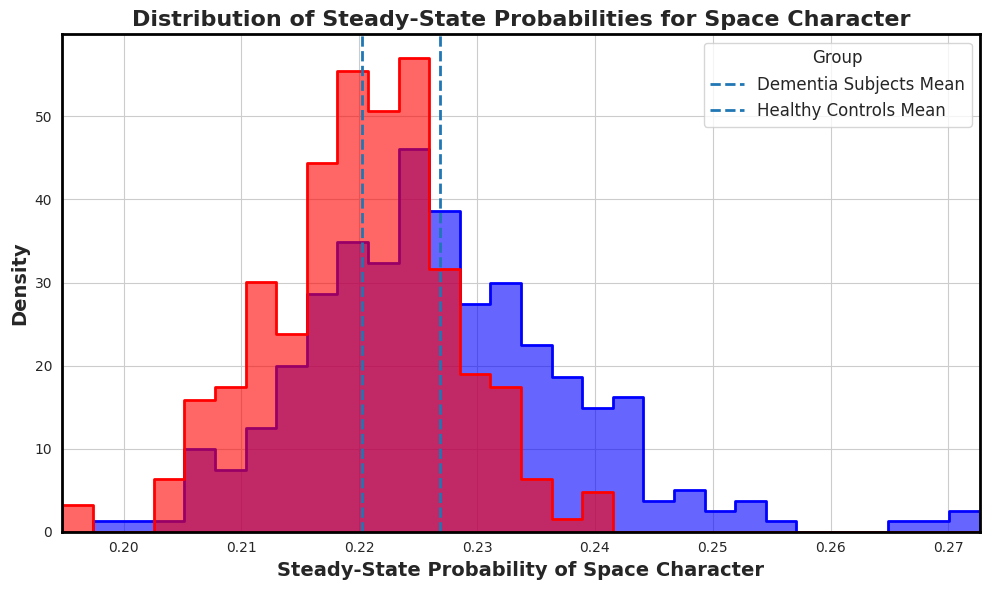

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'steady_state_df' is your DataFrame containing the steady-state probabilities and 'label'
# 'label' column contains 0 for one group (e.g., healthy controls) and 1 for the other group (e.g., dementia patients)

# Map numerical labels to group names for clarity
label_mapping = {0: 'Dementia Subjects', 1: 'Healthy Controls'}
steady_state_df['Group'] = steady_state_df['label'].map(label_mapping)

# Extract the data for the space character
space_data = steady_state_df[[' ', 'Group']]

# Set up the figure size and style
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# Plot the histogram using seaborn's histplot
sns.histplot(
    data=space_data,
    x=' ',
    hue='Group',
    element='step',
    stat='density',
    common_norm=False,
    bins=30,  # Adjust the number of bins for better resolution
    kde=False,
    alpha=0.6,  # Transparency for overlapping
    linewidth=2,
    palette={'Healthy Controls': 'blue', 'Dementia Subjects': 'red'}
)

# Customize the plot to enhance the differences
plt.title('Distribution of Steady-State Probabilities for Space Character', fontsize=16, fontweight='bold')
plt.xlabel('Steady-State Probability of Space Character', fontsize=14, fontweight='bold')
plt.ylabel('Density', fontsize=14, fontweight='bold')

# Adjust the x-axis limits to focus on the area where differences are pronounced
plt.xlim(space_data[' '].min(), space_data[' '].max())

# Enhance the legend
plt.legend(title='Group', fontsize=12, title_fontsize=12)

# Add vertical lines for group means
group_means = space_data.groupby('Group')[' '].mean()
for group, mean_value in group_means.items():
    plt.axvline(mean_value, linestyle='--', linewidth=2, label=f'{group} Mean')



# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase linewidth
    spine.set_color('black')  # Set color to black

# Adjust legend to prevent overlap and include mean lines
plt.legend(title='Group', fontsize=12, title_fontsize=12, loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# List of columns to remove
columns_to_remove = ['cluster', 'composite_feature', 'alternative_composite', 'weighted_composite', 'PC1', 'PC2', 'Group']

# Remove the columns from steady_state_df
steady_state_df.drop(columns=columns_to_remove, errors='ignore', inplace=True)

# Verify the remaining columns
print("Remaining columns in steady_state_df:")
print(steady_state_df.columns.tolist())


Remaining columns in steady_state_df:
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'label']


In [ ]:
# Define the list of important features
important_features = [' ', 'i', 'n', 'c', 'h','l','x','y','j','d']  # Add more features as needed

# Ensure that the features exist in your DataFrame
available_features = [feat for feat in important_features if feat in steady_state_df.columns]
print("Features used in the model:", available_features)

# Prepare the feature matrix X and target variable y
X = steady_state_df[available_features]
y = steady_state_df['label']


Features used in the model: [' ', 'i', 'n', 'c', 'h', 'l', 'x', 'y', 'j', 'd']


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegressionCV

# Define the range of Cs (inverse of regularization strength)
Cs = np.logspace(-2, 2, 50)  # Adjust as needed


In [ ]:
# Initialize LogisticRegressionCV with L1 penalty
lasso_logreg_cv = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l1',
    solver='saga',  # 'saga' supports L1 penalty and is efficient for larger datasets
    scoring='roc_auc',
    max_iter=500,
    tol=1e-3,
    random_state=42,
    refit=True,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1,  # Use all available CPU cores
)

# Fit the model on the scaled training data
lasso_logreg_cv.fit(X_train_scaled, y_train)

# Get the best C (inverse of regularization strength)
best_C = lasso_logreg_cv.C_[0]
print(f"\nBest C (inverse of regularization strength): {best_C}")



Best C (inverse of regularization strength): 12.648552168552959



Model Performance on Test Set:
Accuracy:  0.7169
Precision: 0.7447
Recall:    0.7527
F1 Score:  0.7487
ROC AUC:   0.7945


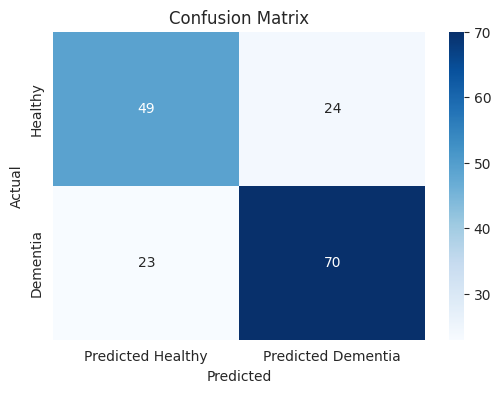

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
y_pred = lasso_logreg_cv.predict(X_test_scaled)
y_pred_prob = lasso_logreg_cv.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nModel Performance on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Healthy', 'Dementia'], columns=['Predicted Healthy', 'Predicted Dementia'])
plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


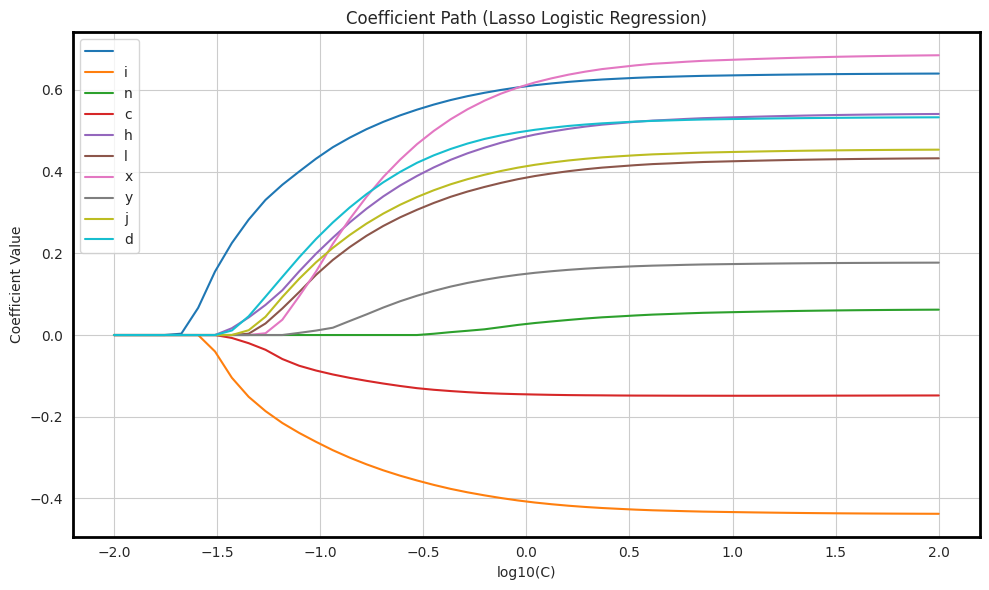

In [ ]:
# Get the coefficients across different Cs
coefs = lasso_logreg_cv.coefs_paths_[1]  # Shape: (n_folds, n_Cs, n_features + 1)

# Average coefficients across folds
mean_coefs = np.mean(coefs, axis=0)  # Shape: (n_Cs, n_features + 1)

# Exclude the intercept term
mean_coefs_no_intercept = mean_coefs[:, :-1]  # Shape: (n_Cs, n_features)

# Number of features
n_features = X_train.shape[1]

# Plotting coefficient paths
plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.plot(np.log10(Cs), mean_coefs_no_intercept[:, i], label=available_features[i])

plt.xlabel('log10(C)')
plt.ylabel('Coefficient Value')


# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase linewidth
    spine.set_color('black')  # Set color to black

plt.title('Coefficient Path (Lasso Logistic Regression)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

# Assuming 'steady_state_df' is your cleaned DataFrame
# It should contain 'label' column (0 for Healthy, 1 for Dementia) and the space character ' '

# Map labels to colors
color_mapping = {0: 'red', 1: 'blue'}
steady_state_df['Color'] = steady_state_df['label'].map(color_mapping)

# Create an index for transcripts
transcript_indices = np.arange(len(steady_state_df))

# Extract the space character usage
space_usage = steady_state_df[' '].values

# Extract the colors for each transcript
colors = steady_state_df['Color'].values

# Create points for the line plot
points = np.array([transcript_indices, space_usage]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Assign colors to each segment based on the label of the starting point
segment_colors = colors[:-1]  # Exclude the last point for segments

# Create a LineCollection
lc = LineCollection(segments, colors=segment_colors, linewidth=2)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Add the LineCollection to the plot
ax.add_collection(lc)

# Set the limits of the plot
ax.set_xlim(transcript_indices.min(), transcript_indices.max())
ax.set_ylim(space_usage.min() - 0.05, space_usage.max() + 0.05)  # Add some padding

# Add titles and labels with bold formatting
plt.title('Variation of Space Character Usage Across Transcripts', fontsize=18, fontweight='bold')
plt.xlabel('Transcript Index', fontsize=16, fontweight='bold')
plt.ylabel('Steady-State Probability of Space Character', fontsize=16, fontweight='bold')

# Customize the plot borders to be bold
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Healthy Control'),
    Line2D([0], [0], color='red', lw=2, label='Dementia Patient')
]
ax.legend(handles=legend_elements, title='Group', fontsize=14, title_fontsize=16)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
#plt.tight_layout()
#plt.show()


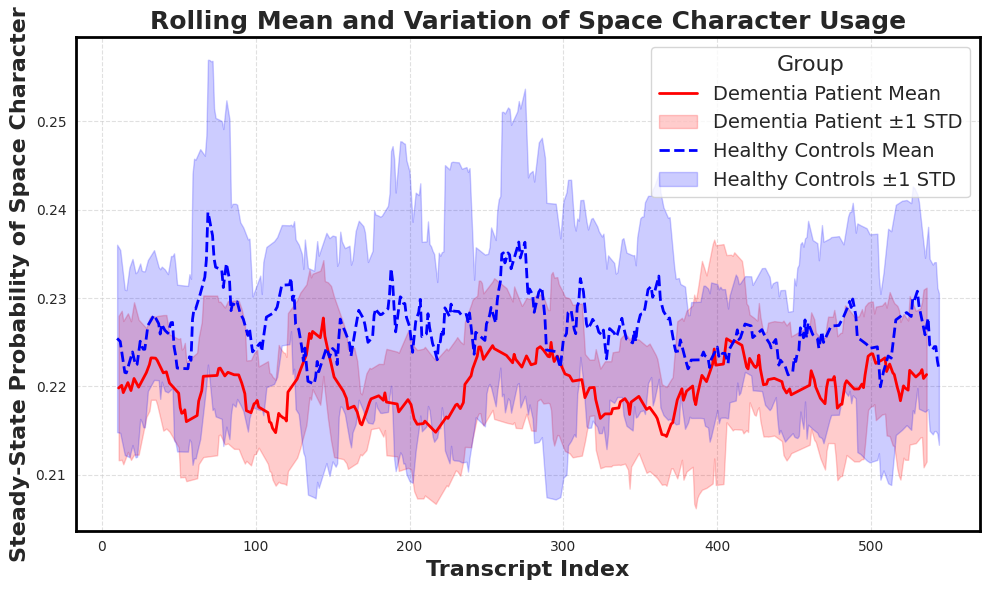

In [ ]:
# Define the window size for rolling statistics
window_size = 10  # Adjust based on your data

# Initialize the figure
plt.figure(figsize=(10, 6))

# Plot rolling mean and standard deviation for each group
for label_value, group_data in steady_state_df.groupby('label'):
    # Compute rolling mean and standard deviation
    rolling_mean = group_data[' '].rolling(window=window_size, center=True).mean()
    rolling_std = group_data[' '].rolling(window=window_size, center=True).std()

    # Plot rolling mean
    plt.plot(
        group_data.index,
        rolling_mean,
        color=color_mapping[label_value],
        linestyle=line_style_mapping.get(label_value, '-'),
        linewidth=2,
        label=f"{label_mapping[label_value]} Mean"
    )

    # Fill the area between (mean - std) and (mean + std)
    plt.fill_between(
        group_data.index,
        rolling_mean - rolling_std,
        rolling_mean + rolling_std,
        color=color_mapping[label_value],
        alpha=0.2,
        label=f"{label_mapping[label_value]} ±1 STD"
    )

# Add titles and labels with bold formatting
plt.title('Rolling Mean and Variation of Space Character Usage', fontsize=18, fontweight='bold')
plt.xlabel('Transcript Index', fontsize=16, fontweight='bold')
plt.ylabel('Steady-State Probability of Space Character', fontsize=16, fontweight='bold')


# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase linewidth
    spine.set_color('black')  # Set color to black

# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Group', fontsize=14, title_fontsize=16)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


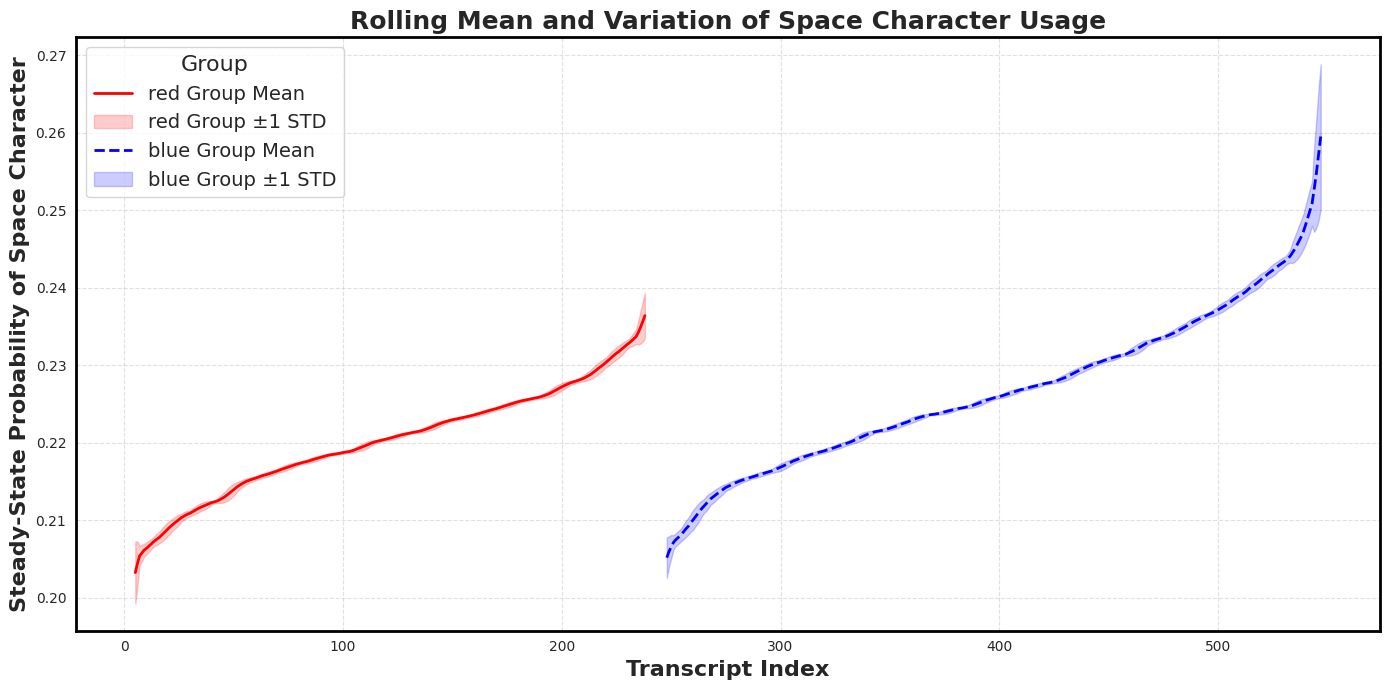

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

# Assuming 'steady_state_df' is your cleaned DataFrame
# It should contain 'label' column (0 for Healthy, 1 for Dementia) and the space character ' '

# Map labels to colors and line styles
color_mapping = {0: 'red', 1: 'blue'}
line_style_mapping = {0: '-', 1: '--'}

steady_state_df['Color'] = steady_state_df['label'].map(color_mapping)
steady_state_df['LineStyle'] = steady_state_df['label'].map(line_style_mapping)

# Sort the DataFrame by 'label' and then by the space character usage
steady_state_df_sorted = steady_state_df.sort_values(by=['label', ' ']).reset_index(drop=True)

# Define the window size for rolling statistics
window_size = 10  # Adjust based on your data

# Initialize the figure
plt.figure(figsize=(14, 7))

# Plot rolling mean and standard deviation for each group
for label_value, group_data in steady_state_df_sorted.groupby('label'):
    # Compute rolling mean and standard deviation
    rolling_mean = group_data[' '].rolling(window=window_size, center=True).mean()
    rolling_std = group_data[' '].rolling(window=window_size, center=True).std()

    # Plot rolling mean
    plt.plot(
        group_data.index,
        rolling_mean,
        color=color_mapping[label_value],
        linestyle=line_style_mapping[label_value],
        linewidth=2,
        label=f"{color_mapping[label_value]} Group Mean"
    )

    # Fill the area between (mean - std) and (mean + std)
    plt.fill_between(
        group_data.index,
        rolling_mean - rolling_std,
        rolling_mean + rolling_std,
        color=color_mapping[label_value],
        alpha=0.2,
        label=f"{color_mapping[label_value]} Group ±1 STD"
    )

# Add titles and labels with bold formatting
plt.title('Rolling Mean and Variation of Space Character Usage', fontsize=18, fontweight='bold')
plt.xlabel('Transcript Index', fontsize=16, fontweight='bold')
plt.ylabel('Steady-State Probability of Space Character', fontsize=16, fontweight='bold')

# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Increase linewidth
    spine.set_color('black')  # Set color to black

# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
# To avoid duplicate legend entries, create a dictionary
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Group', fontsize=14, title_fontsize=16)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure
fig = make_subplots()

# Add rolling mean for Healthy Control
fig.add_trace(go.Scatter(
    x=steady_state_df_sorted[steady_state_df_sorted['label'] == 0].index,
    y=steady_state_df_sorted[steady_state_df_sorted['label'] == 0][' '].rolling(window=window_size, center=True).mean(),
    mode='lines',
    name='Healthy Control Mean',
    line=dict(color='blue', width=2)
))

# Add shaded area for Healthy Control ±1 STD
fig.add_trace(go.Scatter(
    x=steady_state_df_sorted[steady_state_df_sorted['label'] == 0].index,
    y=steady_state_df_sorted[steady_state_df_sorted['label'] == 0][' '].rolling(window=window_size, center=True).mean() + steady_state_df_sorted[steady_state_df_sorted['label'] == 0][' '].rolling(window=window_size, center=True).std(),
    mode='lines',
    name='Healthy Control +1 STD',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=steady_state_df_sorted[steady_state_df_sorted['label'] == 0].index,
    y=steady_state_df_sorted[steady_state_df_sorted['label'] == 0][' '].rolling(window=window_size, center=True).mean() - steady_state_df_sorted[steady_state_df_sorted['label'] == 0][' '].rolling(window=window_size, center=True).std(),
    mode='lines',
    name='Healthy Control -1 STD',
    fill='tonexty',
    line=dict(width=0),
    fillcolor='rgba(0, 0, 255, 0.2)',
    showlegend=False
))

# Repeat for Dementia Patient
fig.add_trace(go.Scatter(
    x=steady_state_df_sorted[steady_state_df_sorted['label'] == 1].index,
    y=steady_state_df_sorted[steady_state_df_sorted['label'] == 1][' '].rolling(window=window_size, center=True).mean(),
    mode='lines',
    name='Dementia Patient Mean',
    line=dict(color='red', width=2)
))

fig.add_trace(go.Scatter(
    x=steady_state_df_sorted[steady_state_df_sorted['label'] == 1].index,
    y=steady_state_df_sorted[steady_state_df_sorted['label'] == 1][' '].rolling(window=window_size, center=True).mean() + steady_state_df_sorted[steady_state_df_sorted['label'] == 1][' '].rolling(window=window_size, center=True).std(),
    mode='lines',
    name='Dementia Patient +1 STD',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=steady_state_df_sorted[steady_state_df_sorted['label'] == 1].index,
    y=steady_state_df_sorted[steady_state_df_sorted['label'] == 1][' '].rolling(window=window_size, center=True).mean() - steady_state_df_sorted[steady_state_df_sorted['label'] == 1][' '].rolling(window=window_size, center=True).std(),
    mode='lines',
    name='Dementia Patient -1 STD',
    fill='tonexty',
    line=dict(width=0),
    fillcolor='rgba(255, 0, 0, 0.2)',
    showlegend=False
))

# Update layout
fig.update_layout(
    title='Rolling Mean and Variation of Space Character Usage',
    xaxis_title='Transcript Index',
    yaxis_title='Steady-State Probability of Space Character',
    legend_title='Group',
    template='plotly_white'
)

# Show plot
fig.show()


In [ ]:
# List of columns to remove (added for plotting purposes)
columns_to_remove = ['cluster', 'composite_feature', 'alternative_composite',
                     'weighted_composite', 'PC1', 'PC2', 'Group', 'Color', 'LineStyle']

# Remove the specified columns
steady_state_df.drop(columns=columns_to_remove, errors='ignore', inplace=True)

# Inspect columns
steady_state_df.columns

Index([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
       'label'],
      dtype='object')

In [ ]:
# Define the feature matrix X and target vector y
X = steady_state_df.drop(columns=['label'], errors='ignore')  # All features
y = steady_state_df['label']

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (386, 27)
Test set size: (166, 27)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features have been scaled.")


Features have been scaled.


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Initialize LogisticRegressionCV with L1 penalty
lasso_logreg_cv = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 20),  # Corrected: Added missing comma
    cv=3,
    penalty='l1',
    solver='saga',  # 'saga' supports L1 penalty and is efficient for larger datasets
    scoring='roc_auc',
    max_iter=500,
    tol=1e-3,
    random_state=42,
    refit=True,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1,  # Use all available CPU cores
)


In [ ]:
# Fit the model on the scaled training data
lasso_logreg_cv.fit(X_train_scaled, y_train)

# Get the best C (inverse of regularization strength)
best_C = lasso_logreg_cv.C_[0]
print(f"\nBest C (inverse of regularization strength): {best_C}")



Best C (inverse of regularization strength): 2.06913808111479


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Make predictions on the test data
y_pred = lasso_logreg_cv.predict(X_test_scaled)
y_pred_prob = lasso_logreg_cv.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nModel Performance on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")



Model Performance on Test Set:
Accuracy:  0.7229
Precision: 0.7640
Recall:    0.7312
F1 Score:  0.7473
ROC AUC:   0.8060


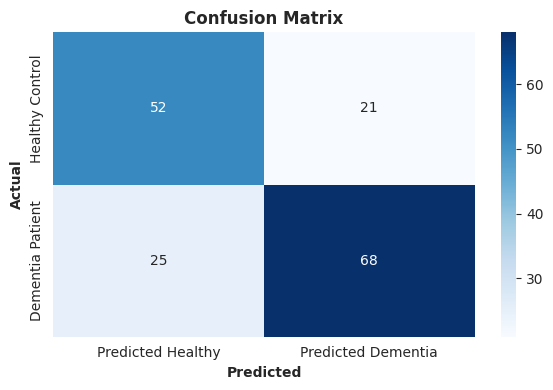

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Healthy Control', 'Dementia Patient'],
                     columns=['Predicted Healthy', 'Predicted Dementia'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')

# Customize the plot borders to be bold and black
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.tight_layout()
plt.show()


In [ ]:
# Extract coefficients and feature names
coef = lasso_logreg_cv.coef_[0]
feature_names = X.columns

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

# Filter non-zero coefficients
non_zero_coefs = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

print("\nNon-zero Coefficients:")
print(non_zero_coefs)



Non-zero Coefficients:
   Feature  Coefficient
0              0.757425
10       j     0.614802
24       x     0.612290
4        d     0.551180
12       l     0.479450
8        h     0.400430
13       m     0.390602
7        g     0.322153
19       s     0.321874
22       v     0.112670
3        c     0.094517
25       y     0.086445
20       t     0.007959
2        b    -0.000539
14       n    -0.018175
26       z    -0.022453
17       q    -0.097084
11       k    -0.099482
18       r    -0.135515
21       u    -0.151937
5        e    -0.211255
1        a    -0.295982
15       o    -0.540880
9        i    -1.005391


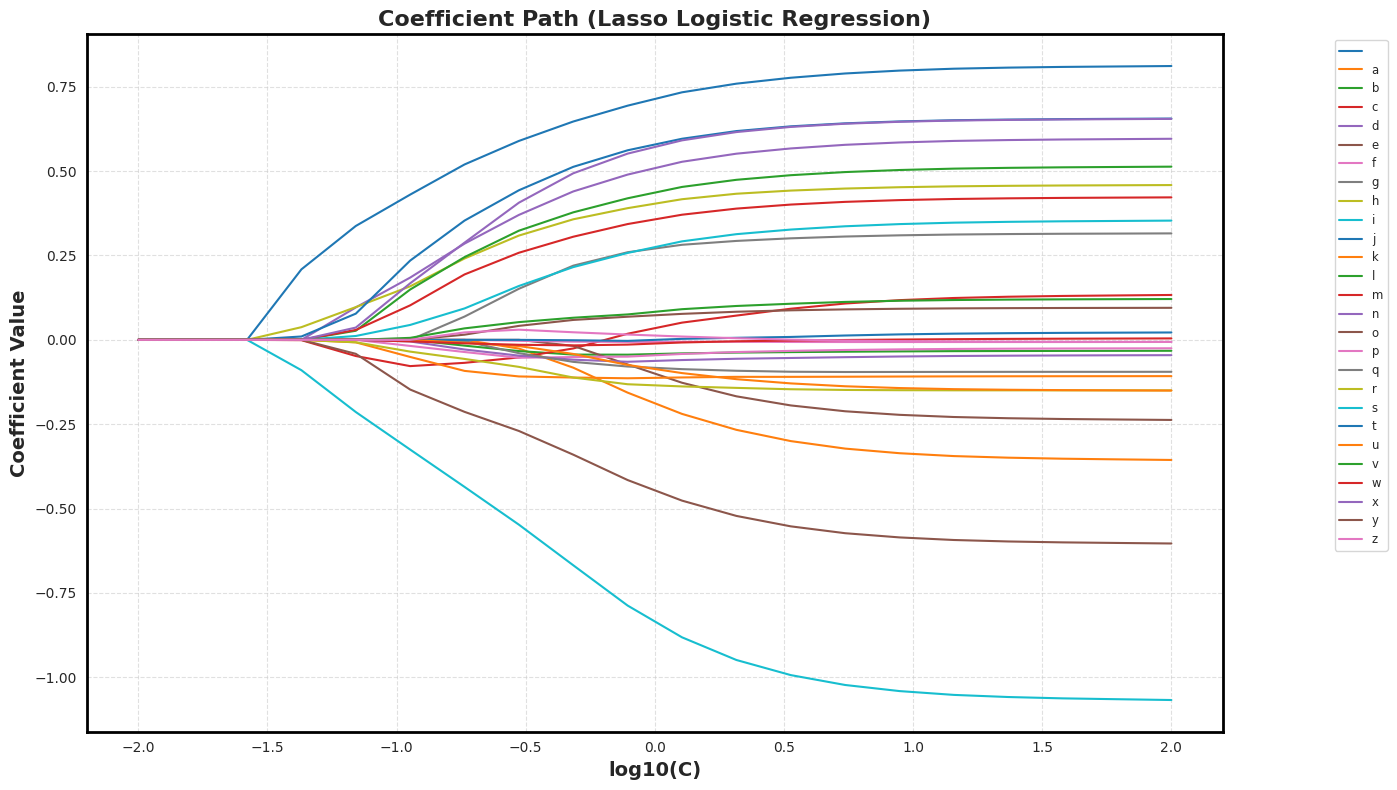

In [ ]:
import numpy as np

# Get the coefficients across different Cs
# coefs_paths_ is of shape (n_classes, n_Cs, n_features + 1)
# For binary classification, we can access class 1
coefs = lasso_logreg_cv.coefs_paths_[1]  # Shape: (n_folds, n_Cs, n_features + 1)

# Average coefficients across folds
mean_coefs = np.mean(coefs, axis=0)  # Shape: (n_Cs, n_features + 1)

# Exclude the intercept term
mean_coefs_no_intercept = mean_coefs[:, :-1]  # Shape: (n_Cs, n_features)

# Number of Cs and features
n_Cs = mean_coefs_no_intercept.shape[0]
n_features = mean_coefs_no_intercept.shape[1]

# Get the list of Cs
Cs = lasso_logreg_cv.Cs_

# Plotting coefficient paths
plt.figure(figsize=(14, 8))
for i in range(n_features):
    plt.plot(np.log10(Cs), mean_coefs_no_intercept[:, i], label=feature_names[i])

plt.xlabel('log10(C)', fontsize=14, fontweight='bold')
plt.ylabel('Coefficient Value', fontsize=14, fontweight='bold')
plt.title('Coefficient Path (Lasso Logistic Regression)', fontsize=16, fontweight='bold')

# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

# Create a legend
# To prevent overcrowding, you might want to show only top features
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small', ncol=1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


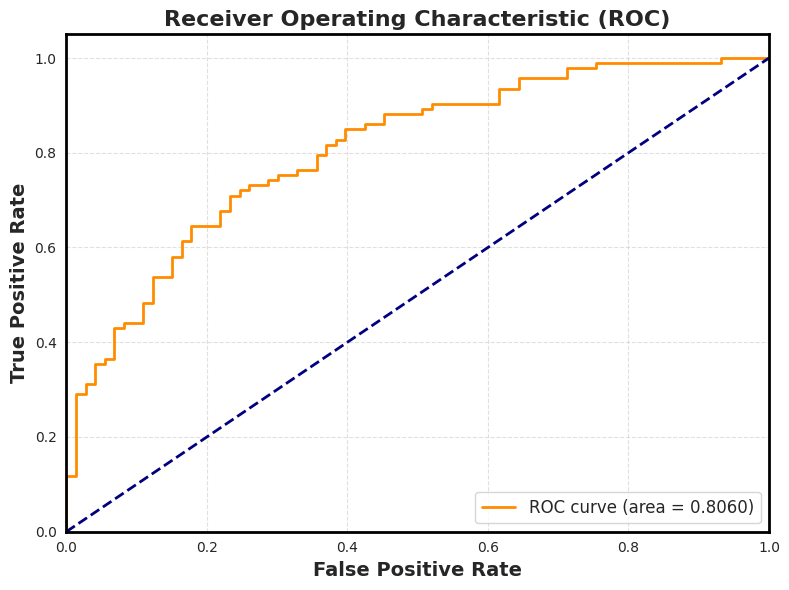

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')

# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


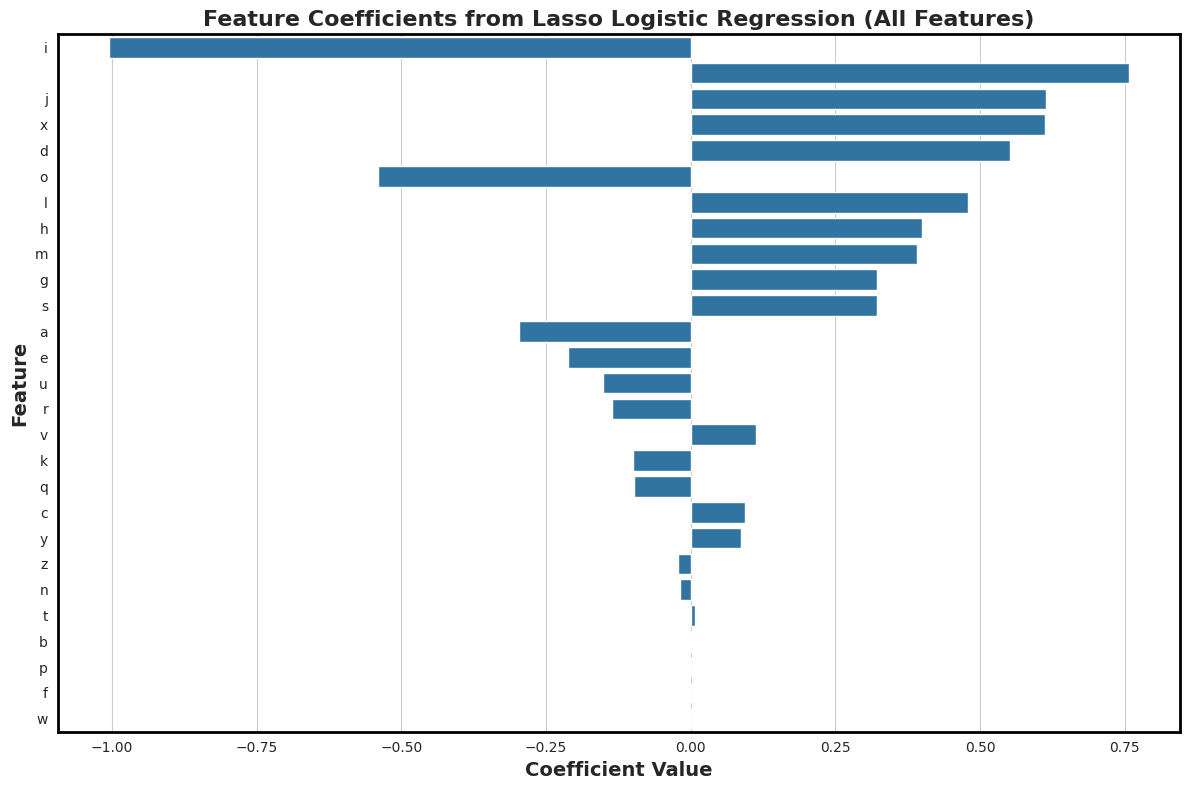

In [ ]:
# Sort coefficients by absolute value
coef_df['abs_coefficient'] = coef_df['Coefficient'].abs()
sorted_coef = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=sorted_coef)
plt.title('Feature Coefficients from Lasso Logistic Regression (All Features)', fontsize=16, fontweight='bold')
plt.xlabel('Coefficient Value', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')

# Customize the plot borders to be black and bold
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.tight_layout()
plt.show()
